In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)),
     transforms.RandomAffine((-5,5), translate=(0.1,0.1), scale=(0.9,1.1), shear=None, resample=False)
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

/home/lebeast/miniconda3/envs/pytorch19/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1343: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [4]:
transform_none = transforms.Compose([transforms.ToTensor(),])

dataset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=False,transform=transform_none)
dataset2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,transform=transform_none)
dataset3 = torch.utils.data.ConcatDataset([dataset1, dataset2])

dataloader = torch.utils.data.DataLoader(dataset3, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print("mean: ", mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print("std: ", std)

0
10000
20000
30000
40000
50000
mean:  tensor([0.4919, 0.4827, 0.4472])
0
10000
20000
30000
40000
50000
std:  tensor([0.2470, 0.2434, 0.2616])


torch.Size([4, 3, 32, 32])
horse   car   car  deer


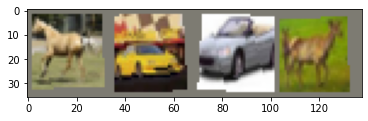

In [5]:
# functions to show an image

def imshow(img):
    #(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    train_loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item()} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item()} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)
    train_accuracy_list.append(100*correct/processed)
  
  print("length of Average loss {}, length of Average accuracy {}".format(len(train_loss_list),len(train_accuracy_list)))
  return train_loss_list, train_accuracy_list


def test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 100: #handtune this for images we need
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print('Test set: Average loss: {:.6f}, Average accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))
    
    return test_loss_list, test_accuracy_list, misclassified_imgs

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


In [8]:
dropout_value = 0.05

class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        
        # # CONVOLUTION BLOCK 1 changed dilation to 1 in first layer
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same', bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, groups=128, bias=False),
            nn.Conv2d(128,256,1),
            #nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(dropout_value)
        ) # Depthwise
        
        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            #nn.ReLU(),
            #nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
            # Depthwise
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, groups=64, bias=False),
            nn.Conv2d(64,128,1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(dropout_value),
            #to remove last fc layer
            nn.Conv2d(128,10,1),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        #self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 10 * 1 * 1)
        return F.log_softmax(x, dim=-1)

temp = Net5().to(device)
summary(temp, 
        (3, 32, 32),
        dtypes=[torch.float],
        branching=False,
        verbose=2,
        col_width=16,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 80
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net5'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.519252061843872 Batch_id=12499 Accuracy=34.44: 100%|██████████| 12500/12500 [00:46<00:00, 267.23it/s]  


length of Average loss 12500, length of Average accuracy 12500

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 1.484233, Average accuracy: 4609/10000 (46.090000%)

EPOCH: 2


Loss=2.2934038639068604 Batch_id=12499 Accuracy=47.44: 100%|██████████| 12500/12500 [00:46<00:00, 268.36it/s] 


length of Average loss 25000, length of Average accuracy 25000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 1.324070, Average accuracy: 5258/10000 (52.580000%)

EPOCH: 3


Loss=2.0597386360168457 Batch_id=12499 Accuracy=52.90: 100%|██████████| 12500/12500 [00:46<00:00, 269.67it/s] 

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 1.149986, Average accuracy: 5868/10000 (58.680000%)

EPOCH: 4


Loss=1.855722427368164 Batch_id=12499 Accuracy=56.27: 100%|██████████| 12500/12500 [00:46<00:00, 266.63it/s]  


length of Average loss 50000, length of Average accuracy 50000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 1.120769, Average accuracy: 5998/10000 (59.980000%)

EPOCH: 5


Loss=2.3335399627685547 Batch_id=12499 Accuracy=58.60: 100%|██████████| 12500/12500 [00:48<00:00, 259.75it/s] 

length of Average loss 62500, length of Average accuracy 62500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 1.059866, Average accuracy: 6252/10000 (62.520000%)

EPOCH: 6


Loss=0.9856557846069336 Batch_id=12499 Accuracy=60.19: 100%|██████████| 12500/12500 [00:47<00:00, 264.14it/s] 

length of Average loss 75000, length of Average accuracy 75000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.996894, Average accuracy: 6452/10000 (64.520000%)

EPOCH: 7


Loss=0.970032811164856 Batch_id=12499 Accuracy=61.80: 100%|██████████| 12500/12500 [00:45<00:00, 273.16it/s]   

length of Average loss 87500, length of Average accuracy 87500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.931165, Average accuracy: 6670/10000 (66.700000%)

EPOCH: 8


Loss=2.643540620803833 Batch_id=12499 Accuracy=63.13: 100%|██████████| 12500/12500 [00:46<00:00, 269.17it/s]   

length of Average loss 100000, length of Average accuracy 100000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.947427, Average accuracy: 6709/10000 (67.090000%)

EPOCH: 9


Loss=0.5350427031517029 Batch_id=12499 Accuracy=64.36: 100%|██████████| 12500/12500 [00:46<00:00, 267.68it/s]  

length of Average loss 112500, length of Average accuracy 112500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.963400, Average accuracy: 6627/10000 (66.270000%)

EPOCH: 10


Loss=0.968795657157898 Batch_id=12499 Accuracy=65.23: 100%|██████████| 12500/12500 [00:46<00:00, 266.06it/s]   

length of Average loss 125000, length of Average accuracy 125000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.873814, Average accuracy: 6878/10000 (68.780000%)

EPOCH: 11


Loss=0.7584483027458191 Batch_id=12499 Accuracy=66.36: 100%|██████████| 12500/12500 [00:46<00:00, 268.82it/s]  

length of Average loss 137500, length of Average accuracy 137500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.861564, Average accuracy: 6959/10000 (69.590000%)

EPOCH: 12


Loss=0.6073458194732666 Batch_id=12499 Accuracy=66.95: 100%|██████████| 12500/12500 [00:46<00:00, 268.12it/s] 


length of Average loss 150000, length of Average accuracy 150000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.849631, Average accuracy: 7086/10000 (70.860000%)

EPOCH: 13


Loss=0.5627496242523193 Batch_id=12499 Accuracy=67.31: 100%|██████████| 12500/12500 [00:48<00:00, 257.68it/s]  

length of Average loss 162500, length of Average accuracy 162500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.828010, Average accuracy: 7065/10000 (70.650000%)

EPOCH: 14


Loss=1.6441270112991333 Batch_id=12499 Accuracy=68.25: 100%|██████████| 12500/12500 [00:47<00:00, 264.32it/s]  

length of Average loss 175000, length of Average accuracy 175000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.832154, Average accuracy: 7049/10000 (70.490000%)

EPOCH: 15


Loss=0.47455573081970215 Batch_id=12499 Accuracy=68.30: 100%|██████████| 12500/12500 [00:46<00:00, 268.48it/s] 

length of Average loss 187500, length of Average accuracy 187500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.791327, Average accuracy: 7240/10000 (72.400000%)

EPOCH: 16


Loss=0.4553976058959961 Batch_id=12499 Accuracy=68.89: 100%|██████████| 12500/12500 [00:46<00:00, 266.84it/s]  


length of Average loss 200000, length of Average accuracy 200000

learning rate 0.01


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.835575, Average accuracy: 7080/10000 (70.800000%)

EPOCH: 17


Loss=1.5919934511184692 Batch_id=12499 Accuracy=69.36: 100%|██████████| 12500/12500 [00:48<00:00, 259.44it/s]  

length of Average loss 212500, length of Average accuracy 212500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.820260, Average accuracy: 7197/10000 (71.970000%)

EPOCH: 18


Loss=0.6806952357292175 Batch_id=12499 Accuracy=69.51: 100%|██████████| 12500/12500 [00:47<00:00, 261.49it/s]  

length of Average loss 225000, length of Average accuracy 225000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.799975, Average accuracy: 7213/10000 (72.130000%)

EPOCH: 19


Loss=0.47106340527534485 Batch_id=12499 Accuracy=69.39: 100%|██████████| 12500/12500 [00:46<00:00, 267.80it/s] 

length of Average loss 237500, length of Average accuracy 237500

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.773306, Average accuracy: 7283/10000 (72.830000%)

EPOCH: 20


Loss=0.3318654000759125 Batch_id=12499 Accuracy=70.34: 100%|██████████| 12500/12500 [00:46<00:00, 269.90it/s]  

length of Average loss 250000, length of Average accuracy 250000

learning rate 0.01



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.743534, Average accuracy: 7390/10000 (73.900000%)

EPOCH: 21


Loss=0.11311148852109909 Batch_id=12499 Accuracy=72.67: 100%|██████████| 12500/12500 [00:46<00:00, 266.46it/s] 

length of Average loss 262500, length of Average accuracy 262500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.717523, Average accuracy: 7525/10000 (75.250000%)

EPOCH: 22


Loss=0.20518361032009125 Batch_id=12499 Accuracy=72.92: 100%|██████████| 12500/12500 [00:46<00:00, 266.33it/s] 

length of Average loss 275000, length of Average accuracy 275000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.693587, Average accuracy: 7596/10000 (75.960000%)

EPOCH: 23


Loss=0.2839406728744507 Batch_id=12499 Accuracy=72.95: 100%|██████████| 12500/12500 [00:46<00:00, 267.91it/s]   

length of Average loss 287500, length of Average accuracy 287500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.710854, Average accuracy: 7528/10000 (75.280000%)

EPOCH: 24


Loss=0.6344608664512634 Batch_id=12499 Accuracy=73.23: 100%|██████████| 12500/12500 [00:46<00:00, 267.76it/s]   

length of Average loss 300000, length of Average accuracy 300000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.719258, Average accuracy: 7554/10000 (75.540000%)

EPOCH: 25


Loss=0.38395464420318604 Batch_id=12499 Accuracy=73.67: 100%|██████████| 12500/12500 [00:46<00:00, 266.02it/s] 

length of Average loss 312500, length of Average accuracy 312500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.686621, Average accuracy: 7628/10000 (76.280000%)

EPOCH: 26


Loss=1.133630633354187 Batch_id=12499 Accuracy=73.30: 100%|██████████| 12500/12500 [00:46<00:00, 268.05it/s]   

length of Average loss 325000, length of Average accuracy 325000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.675258, Average accuracy: 7672/10000 (76.720000%)

EPOCH: 27


Loss=0.29684779047966003 Batch_id=12499 Accuracy=73.58: 100%|██████████| 12500/12500 [00:46<00:00, 268.55it/s] 

length of Average loss 337500, length of Average accuracy 337500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.687251, Average accuracy: 7591/10000 (75.910000%)

EPOCH: 28


Loss=1.168457269668579 Batch_id=12499 Accuracy=73.73: 100%|██████████| 12500/12500 [00:46<00:00, 266.13it/s]    

length of Average loss 350000, length of Average accuracy 350000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.693977, Average accuracy: 7614/10000 (76.140000%)

EPOCH: 29


Loss=0.7290182113647461 Batch_id=12499 Accuracy=73.91: 100%|██████████| 12500/12500 [00:47<00:00, 262.48it/s]   

length of Average loss 362500, length of Average accuracy 362500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.700112, Average accuracy: 7544/10000 (75.440000%)

EPOCH: 30


Loss=1.7082648277282715 Batch_id=12499 Accuracy=74.00: 100%|██████████| 12500/12500 [00:46<00:00, 268.85it/s]  

length of Average loss 375000, length of Average accuracy 375000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.673155, Average accuracy: 7658/10000 (76.580000%)

EPOCH: 31


Loss=0.0633644312620163 Batch_id=12499 Accuracy=74.19: 100%|██████████| 12500/12500 [00:46<00:00, 267.14it/s]   

length of Average loss 387500, length of Average accuracy 387500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.662523, Average accuracy: 7728/10000 (77.280000%)

EPOCH: 32


Loss=1.95762300491333 Batch_id=12499 Accuracy=74.09: 100%|██████████| 12500/12500 [00:46<00:00, 266.46it/s]    


length of Average loss 400000, length of Average accuracy 400000

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.689101, Average accuracy: 7655/10000 (76.550000%)

EPOCH: 33


Loss=0.8346007466316223 Batch_id=12499 Accuracy=74.62: 100%|██████████| 12500/12500 [00:47<00:00, 262.91it/s]   

length of Average loss 412500, length of Average accuracy 412500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.672566, Average accuracy: 7655/10000 (76.550000%)

EPOCH: 34


Loss=0.06947077065706253 Batch_id=12499 Accuracy=74.43: 100%|██████████| 12500/12500 [00:46<00:00, 268.68it/s] 

length of Average loss 425000, length of Average accuracy 425000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.660466, Average accuracy: 7673/10000 (76.730000%)

EPOCH: 35


Loss=0.13876751065254211 Batch_id=12499 Accuracy=74.42: 100%|██████████| 12500/12500 [00:46<00:00, 267.89it/s]  

length of Average loss 437500, length of Average accuracy 437500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.662940, Average accuracy: 7660/10000 (76.600000%)

EPOCH: 36


Loss=0.5134998559951782 Batch_id=12499 Accuracy=74.44: 100%|██████████| 12500/12500 [00:46<00:00, 269.66it/s]  

length of Average loss 450000, length of Average accuracy 450000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.663283, Average accuracy: 7655/10000 (76.550000%)

EPOCH: 37


Loss=1.5814725160598755 Batch_id=12499 Accuracy=74.47: 100%|██████████| 12500/12500 [00:46<00:00, 267.93it/s]  

length of Average loss 462500, length of Average accuracy 462500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.653578, Average accuracy: 7707/10000 (77.070000%)

EPOCH: 38


Loss=0.86954665184021 Batch_id=12499 Accuracy=74.77: 100%|██████████| 12500/12500 [00:47<00:00, 261.63it/s]     

length of Average loss 475000, length of Average accuracy 475000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.654208, Average accuracy: 7742/10000 (77.420000%)

EPOCH: 39


Loss=0.7811304926872253 Batch_id=12499 Accuracy=74.76: 100%|██████████| 12500/12500 [00:46<00:00, 269.31it/s]   

length of Average loss 487500, length of Average accuracy 487500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.671107, Average accuracy: 7654/10000 (76.540000%)

EPOCH: 40


Loss=1.3279393911361694 Batch_id=12499 Accuracy=74.87: 100%|██████████| 12500/12500 [00:47<00:00, 265.66it/s]   

length of Average loss 500000, length of Average accuracy 500000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.650351, Average accuracy: 7780/10000 (77.800000%)

EPOCH: 41


Loss=1.1076430082321167 Batch_id=12499 Accuracy=75.96: 100%|██████████| 12500/12500 [00:50<00:00, 249.57it/s]   

length of Average loss 512500, length of Average accuracy 512500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.640559, Average accuracy: 7753/10000 (77.530000%)

EPOCH: 42


Loss=0.50522381067276 Batch_id=12499 Accuracy=76.00: 100%|██████████| 12500/12500 [00:50<00:00, 248.53it/s]    

length of Average loss 525000, length of Average accuracy 525000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.642522, Average accuracy: 7766/10000 (77.660000%)

EPOCH: 43


Loss=0.8186452388763428 Batch_id=12499 Accuracy=76.12: 100%|██████████| 12500/12500 [00:50<00:00, 249.50it/s]   

length of Average loss 537500, length of Average accuracy 537500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.627557, Average accuracy: 7776/10000 (77.760000%)

EPOCH: 44


Loss=0.40536874532699585 Batch_id=12499 Accuracy=76.33: 100%|██████████| 12500/12500 [00:50<00:00, 248.99it/s]  

length of Average loss 550000, length of Average accuracy 550000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.622606, Average accuracy: 7839/10000 (78.390000%)

EPOCH: 45


Loss=1.0184556245803833 Batch_id=12499 Accuracy=76.54: 100%|██████████| 12500/12500 [00:50<00:00, 249.56it/s]  

length of Average loss 562500, length of Average accuracy 562500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.622186, Average accuracy: 7795/10000 (77.950000%)

EPOCH: 46


Loss=1.3794554471969604 Batch_id=12499 Accuracy=76.23: 100%|██████████| 12500/12500 [00:49<00:00, 250.54it/s]  

length of Average loss 575000, length of Average accuracy 575000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.622846, Average accuracy: 7863/10000 (78.630000%)

EPOCH: 47


Loss=0.3248681426048279 Batch_id=12499 Accuracy=76.41: 100%|██████████| 12500/12500 [00:49<00:00, 250.25it/s]   

length of Average loss 587500, length of Average accuracy 587500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.618297, Average accuracy: 7823/10000 (78.230000%)

EPOCH: 48


Loss=0.9317519664764404 Batch_id=12499 Accuracy=76.39: 100%|██████████| 12500/12500 [00:50<00:00, 249.21it/s]   


length of Average loss 600000, length of Average accuracy 600000

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.625728, Average accuracy: 7806/10000 (78.060000%)

EPOCH: 49


Loss=0.8047631978988647 Batch_id=12499 Accuracy=76.68: 100%|██████████| 12500/12500 [00:50<00:00, 249.76it/s]   


length of Average loss 612500, length of Average accuracy 612500

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.623429, Average accuracy: 7842/10000 (78.420000%)

EPOCH: 50


Loss=1.0071933269500732 Batch_id=12499 Accuracy=76.71: 100%|██████████| 12500/12500 [00:50<00:00, 247.03it/s]   

length of Average loss 625000, length of Average accuracy 625000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.634734, Average accuracy: 7808/10000 (78.080000%)

EPOCH: 51


Loss=0.39290544390678406 Batch_id=12499 Accuracy=76.71: 100%|██████████| 12500/12500 [00:50<00:00, 248.58it/s]  

length of Average loss 637500, length of Average accuracy 637500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.619890, Average accuracy: 7875/10000 (78.750000%)

EPOCH: 52


Loss=1.2055432796478271 Batch_id=12499 Accuracy=76.61: 100%|██████████| 12500/12500 [00:50<00:00, 247.71it/s]   

length of Average loss 650000, length of Average accuracy 650000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.607950, Average accuracy: 7872/10000 (78.720000%)

EPOCH: 53


Loss=0.5002104043960571 Batch_id=12499 Accuracy=76.78: 100%|██████████| 12500/12500 [00:50<00:00, 246.57it/s]  

length of Average loss 662500, length of Average accuracy 662500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.608617, Average accuracy: 7866/10000 (78.660000%)

EPOCH: 54


Loss=0.20044183731079102 Batch_id=12499 Accuracy=76.84: 100%|██████████| 12500/12500 [00:50<00:00, 246.75it/s] 

length of Average loss 675000, length of Average accuracy 675000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.606679, Average accuracy: 7875/10000 (78.750000%)

EPOCH: 55


Loss=1.0724033117294312 Batch_id=12499 Accuracy=76.68: 100%|██████████| 12500/12500 [00:50<00:00, 246.66it/s]  

length of Average loss 687500, length of Average accuracy 687500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.617574, Average accuracy: 7868/10000 (78.680000%)

EPOCH: 56


Loss=0.1681852787733078 Batch_id=12499 Accuracy=76.94: 100%|██████████| 12500/12500 [00:50<00:00, 247.07it/s]  

length of Average loss 700000, length of Average accuracy 700000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.616064, Average accuracy: 7840/10000 (78.400000%)

EPOCH: 57


Loss=1.53548002243042 Batch_id=12499 Accuracy=76.79: 100%|██████████| 12500/12500 [00:50<00:00, 246.79it/s]     

length of Average loss 712500, length of Average accuracy 712500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.606099, Average accuracy: 7897/10000 (78.970000%)

EPOCH: 58


Loss=0.868872344493866 Batch_id=12499 Accuracy=76.77: 100%|██████████| 12500/12500 [00:50<00:00, 247.50it/s]    

length of Average loss 725000, length of Average accuracy 725000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.608412, Average accuracy: 7867/10000 (78.670000%)

EPOCH: 59


Loss=0.19948938488960266 Batch_id=12499 Accuracy=76.84: 100%|██████████| 12500/12500 [00:50<00:00, 247.74it/s]  

length of Average loss 737500, length of Average accuracy 737500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.614403, Average accuracy: 7869/10000 (78.690000%)

EPOCH: 60


Loss=0.5084723234176636 Batch_id=12499 Accuracy=77.01: 100%|██████████| 12500/12500 [00:50<00:00, 245.80it/s]  

length of Average loss 750000, length of Average accuracy 750000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.608318, Average accuracy: 7893/10000 (78.930000%)

EPOCH: 61


Loss=0.043937891721725464 Batch_id=12499 Accuracy=77.48: 100%|██████████| 12500/12500 [00:50<00:00, 247.16it/s]

length of Average loss 762500, length of Average accuracy 762500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.599572, Average accuracy: 7916/10000 (79.160000%)

EPOCH: 62


Loss=1.1736871004104614 Batch_id=12499 Accuracy=77.51: 100%|██████████| 12500/12500 [00:50<00:00, 247.76it/s]   

length of Average loss 775000, length of Average accuracy 775000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.593266, Average accuracy: 7944/10000 (79.440000%)

EPOCH: 63


Loss=0.564568042755127 Batch_id=12499 Accuracy=77.82: 100%|██████████| 12500/12500 [00:50<00:00, 247.31it/s]    

length of Average loss 787500, length of Average accuracy 787500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.602097, Average accuracy: 7905/10000 (79.050000%)

EPOCH: 64


Loss=1.2389459609985352 Batch_id=12499 Accuracy=77.69: 100%|██████████| 12500/12500 [00:50<00:00, 246.39it/s]  

length of Average loss 800000, length of Average accuracy 800000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.605881, Average accuracy: 7892/10000 (78.920000%)

EPOCH: 65


Loss=0.5500428676605225 Batch_id=12499 Accuracy=77.86: 100%|██████████| 12500/12500 [00:50<00:00, 246.71it/s]   

length of Average loss 812500, length of Average accuracy 812500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.592510, Average accuracy: 7905/10000 (79.050000%)

EPOCH: 66


Loss=0.050610899925231934 Batch_id=12499 Accuracy=77.64: 100%|██████████| 12500/12500 [00:50<00:00, 246.43it/s]  


length of Average loss 825000, length of Average accuracy 825000

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.603667, Average accuracy: 7884/10000 (78.840000%)

EPOCH: 67


Loss=0.2096606194972992 Batch_id=12499 Accuracy=77.64: 100%|██████████| 12500/12500 [00:50<00:00, 246.86it/s]   

length of Average loss 837500, length of Average accuracy 837500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.589855, Average accuracy: 7931/10000 (79.310000%)

EPOCH: 68


Loss=1.2188520431518555 Batch_id=12499 Accuracy=77.61: 100%|██████████| 12500/12500 [00:50<00:00, 247.12it/s]   

length of Average loss 850000, length of Average accuracy 850000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.586742, Average accuracy: 8011/10000 (80.110000%)

EPOCH: 69


Loss=0.3544403314590454 Batch_id=12499 Accuracy=77.75: 100%|██████████| 12500/12500 [00:50<00:00, 248.29it/s]   


length of Average loss 862500, length of Average accuracy 862500

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.587095, Average accuracy: 7971/10000 (79.710000%)

EPOCH: 70


Loss=0.8195798993110657 Batch_id=12499 Accuracy=78.22: 100%|██████████| 12500/12500 [00:50<00:00, 248.18it/s]   

length of Average loss 875000, length of Average accuracy 875000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.588009, Average accuracy: 7976/10000 (79.760000%)

EPOCH: 71


Loss=0.0678853988647461 Batch_id=12499 Accuracy=78.02: 100%|██████████| 12500/12500 [00:50<00:00, 246.97it/s]   


length of Average loss 887500, length of Average accuracy 887500

learning rate 0.00125


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.595351, Average accuracy: 7903/10000 (79.030000%)

EPOCH: 72


Loss=0.1612890064716339 Batch_id=12499 Accuracy=78.01: 100%|██████████| 12500/12500 [00:50<00:00, 246.60it/s]   

length of Average loss 900000, length of Average accuracy 900000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.583352, Average accuracy: 7987/10000 (79.870000%)

EPOCH: 73


Loss=0.3511312007904053 Batch_id=12499 Accuracy=78.00: 100%|██████████| 12500/12500 [00:50<00:00, 247.09it/s]   

length of Average loss 912500, length of Average accuracy 912500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.588086, Average accuracy: 7950/10000 (79.500000%)

EPOCH: 74


Loss=0.2468259036540985 Batch_id=12499 Accuracy=77.81: 100%|██████████| 12500/12500 [00:50<00:00, 246.94it/s]  

length of Average loss 925000, length of Average accuracy 925000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.586776, Average accuracy: 7959/10000 (79.590000%)

EPOCH: 75


Loss=0.09038373827934265 Batch_id=12499 Accuracy=77.97: 100%|██████████| 12500/12500 [00:50<00:00, 247.30it/s]  

length of Average loss 937500, length of Average accuracy 937500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.591239, Average accuracy: 7940/10000 (79.400000%)

EPOCH: 76


Loss=0.7017961740493774 Batch_id=12499 Accuracy=78.00: 100%|██████████| 12500/12500 [00:50<00:00, 247.33it/s]   

length of Average loss 950000, length of Average accuracy 950000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.589701, Average accuracy: 7947/10000 (79.470000%)

EPOCH: 77


Loss=0.15046027302742004 Batch_id=12499 Accuracy=78.09: 100%|██████████| 12500/12500 [00:50<00:00, 247.14it/s]  

length of Average loss 962500, length of Average accuracy 962500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.588922, Average accuracy: 7918/10000 (79.180000%)

EPOCH: 78


Loss=0.4851838946342468 Batch_id=12499 Accuracy=78.02: 100%|██████████| 12500/12500 [00:50<00:00, 247.29it/s]   

length of Average loss 975000, length of Average accuracy 975000

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.584214, Average accuracy: 7947/10000 (79.470000%)

EPOCH: 79


Loss=1.9435367584228516 Batch_id=12499 Accuracy=78.09: 100%|██████████| 12500/12500 [00:50<00:00, 247.62it/s]   

length of Average loss 987500, length of Average accuracy 987500

learning rate 0.00125



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.589389, Average accuracy: 7956/10000 (79.560000%)

EPOCH: 80


Loss=1.2158715724945068 Batch_id=12499 Accuracy=78.11: 100%|██████████| 12500/12500 [00:50<00:00, 246.15it/s]   

length of Average loss 1000000, length of Average accuracy 1000000

learning rate 0.00125


Test set: Average loss: 0.579285, Average accuracy: 7956/10000 (79.560000%)



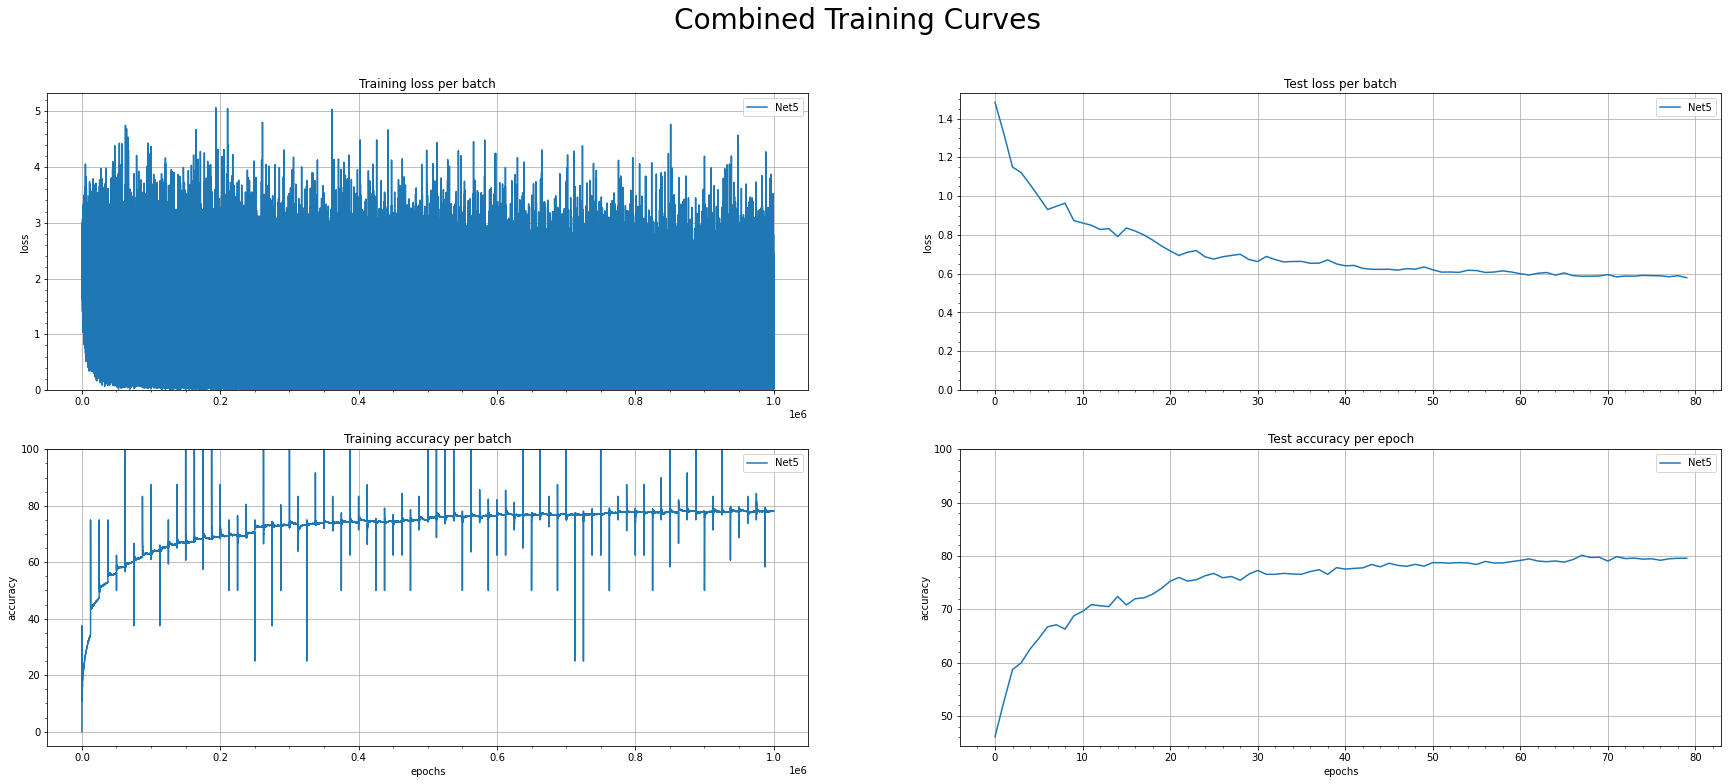

In [10]:
training_curves(history)

In [11]:
EPOCHS = 40
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run SAME model with different lr schedule to try
#model = Net5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01*0.5, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

#this time only append info in history
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.2653367519378662 Batch_id=12499 Accuracy=76.49: 100%|██████████| 12500/12500 [00:50<00:00, 246.51it/s]   


length of Average loss 12500, length of Average accuracy 12500

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.633003, Average accuracy: 7815/10000 (78.150000%)

EPOCH: 2


Loss=0.1138199046254158 Batch_id=12499 Accuracy=76.17: 100%|██████████| 12500/12500 [00:50<00:00, 245.41it/s]  

length of Average loss 25000, length of Average accuracy 25000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.615355, Average accuracy: 7892/10000 (78.920000%)

EPOCH: 3


Loss=1.1012611389160156 Batch_id=12499 Accuracy=76.02: 100%|██████████| 12500/12500 [00:50<00:00, 246.62it/s]  

length of Average loss 37500, length of Average accuracy 37500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.618011, Average accuracy: 7875/10000 (78.750000%)

EPOCH: 4


Loss=0.13902609050273895 Batch_id=12499 Accuracy=76.13: 100%|██████████| 12500/12500 [00:50<00:00, 246.02it/s]  

length of Average loss 50000, length of Average accuracy 50000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.623500, Average accuracy: 7858/10000 (78.580000%)

EPOCH: 5


Loss=1.0426268577575684 Batch_id=12499 Accuracy=76.19: 100%|██████████| 12500/12500 [00:50<00:00, 245.66it/s]   

length of Average loss 62500, length of Average accuracy 62500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.631080, Average accuracy: 7826/10000 (78.260000%)

EPOCH: 6


Loss=0.03447210416197777 Batch_id=12499 Accuracy=76.07: 100%|██████████| 12500/12500 [00:50<00:00, 246.69it/s]  

length of Average loss 75000, length of Average accuracy 75000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.637527, Average accuracy: 7801/10000 (78.010000%)

EPOCH: 7


Loss=0.14494739472866058 Batch_id=12499 Accuracy=76.09: 100%|██████████| 12500/12500 [00:50<00:00, 247.05it/s]  

length of Average loss 87500, length of Average accuracy 87500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.621250, Average accuracy: 7845/10000 (78.450000%)

EPOCH: 8


Loss=0.7420117855072021 Batch_id=12499 Accuracy=76.33: 100%|██████████| 12500/12500 [00:50<00:00, 246.88it/s]  

length of Average loss 100000, length of Average accuracy 100000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.640269, Average accuracy: 7771/10000 (77.710000%)

EPOCH: 9


Loss=0.6262223124504089 Batch_id=12499 Accuracy=76.44: 100%|██████████| 12500/12500 [00:50<00:00, 246.23it/s]   

length of Average loss 112500, length of Average accuracy 112500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.642872, Average accuracy: 7771/10000 (77.710000%)

EPOCH: 10


Loss=0.25042062997817993 Batch_id=12499 Accuracy=76.24: 100%|██████████| 12500/12500 [00:50<00:00, 249.95it/s]  

length of Average loss 125000, length of Average accuracy 125000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.619579, Average accuracy: 7830/10000 (78.300000%)

EPOCH: 11


Loss=0.23833458125591278 Batch_id=12499 Accuracy=76.12: 100%|██████████| 12500/12500 [00:49<00:00, 250.87it/s] 

length of Average loss 137500, length of Average accuracy 137500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.620907, Average accuracy: 7855/10000 (78.550000%)

EPOCH: 12


Loss=0.5020749568939209 Batch_id=12499 Accuracy=76.29: 100%|██████████| 12500/12500 [00:50<00:00, 249.83it/s]  


length of Average loss 150000, length of Average accuracy 150000

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.626537, Average accuracy: 7832/10000 (78.320000%)

EPOCH: 13


Loss=0.25173723697662354 Batch_id=12499 Accuracy=76.07: 100%|██████████| 12500/12500 [00:50<00:00, 249.15it/s]  

length of Average loss 162500, length of Average accuracy 162500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.610046, Average accuracy: 7853/10000 (78.530000%)

EPOCH: 14


Loss=0.7757617235183716 Batch_id=12499 Accuracy=76.42: 100%|██████████| 12500/12500 [00:49<00:00, 250.26it/s]   


length of Average loss 175000, length of Average accuracy 175000

learning rate 0.005


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.647603, Average accuracy: 7756/10000 (77.560000%)

EPOCH: 15


Loss=2.3582231998443604 Batch_id=12499 Accuracy=76.50: 100%|██████████| 12500/12500 [00:49<00:00, 251.19it/s]  

length of Average loss 187500, length of Average accuracy 187500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.639996, Average accuracy: 7732/10000 (77.320000%)

EPOCH: 16


Loss=0.7435711026191711 Batch_id=12499 Accuracy=76.41: 100%|██████████| 12500/12500 [00:50<00:00, 249.93it/s]   

length of Average loss 200000, length of Average accuracy 200000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.631108, Average accuracy: 7805/10000 (78.050000%)

EPOCH: 17


Loss=1.2238824367523193 Batch_id=12499 Accuracy=76.61: 100%|██████████| 12500/12500 [00:50<00:00, 247.55it/s]   

length of Average loss 212500, length of Average accuracy 212500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.625294, Average accuracy: 7812/10000 (78.120000%)

EPOCH: 18


Loss=0.9308614134788513 Batch_id=12499 Accuracy=76.69: 100%|██████████| 12500/12500 [00:49<00:00, 252.01it/s]  

length of Average loss 225000, length of Average accuracy 225000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.612622, Average accuracy: 7890/10000 (78.900000%)

EPOCH: 19


Loss=0.5401593446731567 Batch_id=12499 Accuracy=76.53: 100%|██████████| 12500/12500 [00:50<00:00, 248.58it/s]   

length of Average loss 237500, length of Average accuracy 237500

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.619134, Average accuracy: 7867/10000 (78.670000%)

EPOCH: 20


Loss=0.15041662752628326 Batch_id=12499 Accuracy=76.56: 100%|██████████| 12500/12500 [00:49<00:00, 252.38it/s]  

length of Average loss 250000, length of Average accuracy 250000

learning rate 0.005



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.622226, Average accuracy: 7826/10000 (78.260000%)

EPOCH: 21


Loss=0.09132638573646545 Batch_id=12499 Accuracy=77.71: 100%|██████████| 12500/12500 [00:49<00:00, 250.47it/s]  

length of Average loss 262500, length of Average accuracy 262500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.590857, Average accuracy: 7950/10000 (79.500000%)

EPOCH: 22


Loss=0.41427820920944214 Batch_id=12499 Accuracy=77.71: 100%|██████████| 12500/12500 [00:49<00:00, 250.59it/s]  

length of Average loss 275000, length of Average accuracy 275000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.596937, Average accuracy: 7890/10000 (78.900000%)

EPOCH: 23


Loss=0.1177431121468544 Batch_id=12499 Accuracy=78.24: 100%|██████████| 12500/12500 [00:50<00:00, 249.47it/s]  

length of Average loss 287500, length of Average accuracy 287500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.579733, Average accuracy: 8004/10000 (80.040000%)

EPOCH: 24


Loss=0.23450236022472382 Batch_id=12499 Accuracy=77.82: 100%|██████████| 12500/12500 [00:50<00:00, 246.77it/s]  

length of Average loss 300000, length of Average accuracy 300000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.579470, Average accuracy: 7977/10000 (79.770000%)

EPOCH: 25


Loss=0.9087983965873718 Batch_id=12499 Accuracy=78.11: 100%|██████████| 12500/12500 [00:51<00:00, 241.94it/s]   

length of Average loss 312500, length of Average accuracy 312500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.594153, Average accuracy: 7912/10000 (79.120000%)

EPOCH: 26


Loss=0.6859268546104431 Batch_id=12499 Accuracy=78.14: 100%|██████████| 12500/12500 [00:51<00:00, 244.55it/s]   

length of Average loss 325000, length of Average accuracy 325000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.575435, Average accuracy: 7994/10000 (79.940000%)

EPOCH: 27


Loss=1.6190800666809082 Batch_id=12499 Accuracy=78.25: 100%|██████████| 12500/12500 [00:50<00:00, 247.67it/s]   


length of Average loss 337500, length of Average accuracy 337500

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.589657, Average accuracy: 7950/10000 (79.500000%)

EPOCH: 28


Loss=0.3450831472873688 Batch_id=12499 Accuracy=78.37: 100%|██████████| 12500/12500 [00:50<00:00, 245.33it/s]   


length of Average loss 350000, length of Average accuracy 350000

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.588868, Average accuracy: 7969/10000 (79.690000%)

EPOCH: 29


Loss=0.19115518033504486 Batch_id=12499 Accuracy=78.18: 100%|██████████| 12500/12500 [00:50<00:00, 247.32it/s]  

length of Average loss 362500, length of Average accuracy 362500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.585335, Average accuracy: 7912/10000 (79.120000%)

EPOCH: 30


Loss=1.4485687017440796 Batch_id=12499 Accuracy=78.06: 100%|██████████| 12500/12500 [00:50<00:00, 248.72it/s]   

length of Average loss 375000, length of Average accuracy 375000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.582101, Average accuracy: 7973/10000 (79.730000%)

EPOCH: 31


Loss=1.5796427726745605 Batch_id=12499 Accuracy=78.44: 100%|██████████| 12500/12500 [00:50<00:00, 247.16it/s]   

length of Average loss 387500, length of Average accuracy 387500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.590110, Average accuracy: 7945/10000 (79.450000%)

EPOCH: 32


Loss=0.7845247983932495 Batch_id=12499 Accuracy=78.37: 100%|██████████| 12500/12500 [00:50<00:00, 248.80it/s]   

length of Average loss 400000, length of Average accuracy 400000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.571077, Average accuracy: 8034/10000 (80.340000%)

EPOCH: 33


Loss=1.2284117937088013 Batch_id=12499 Accuracy=78.33: 100%|██████████| 12500/12500 [00:50<00:00, 248.33it/s]  

length of Average loss 412500, length of Average accuracy 412500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.583995, Average accuracy: 7977/10000 (79.770000%)

EPOCH: 34


Loss=0.7254748940467834 Batch_id=12499 Accuracy=78.32: 100%|██████████| 12500/12500 [00:50<00:00, 249.18it/s]   

length of Average loss 425000, length of Average accuracy 425000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.570701, Average accuracy: 8006/10000 (80.060000%)

EPOCH: 35


Loss=1.6821815967559814 Batch_id=12499 Accuracy=78.48: 100%|██████████| 12500/12500 [00:50<00:00, 247.69it/s]   

length of Average loss 437500, length of Average accuracy 437500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.564110, Average accuracy: 8067/10000 (80.670000%)

EPOCH: 36


Loss=0.8890804648399353 Batch_id=12499 Accuracy=78.43: 100%|██████████| 12500/12500 [00:50<00:00, 247.15it/s]  

length of Average loss 450000, length of Average accuracy 450000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.580203, Average accuracy: 7945/10000 (79.450000%)

EPOCH: 37


Loss=0.3510695695877075 Batch_id=12499 Accuracy=78.38: 100%|██████████| 12500/12500 [00:50<00:00, 249.07it/s]  


length of Average loss 462500, length of Average accuracy 462500

learning rate 0.0025


  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.575267, Average accuracy: 8039/10000 (80.390000%)

EPOCH: 38


Loss=0.585103452205658 Batch_id=12499 Accuracy=78.45: 100%|██████████| 12500/12500 [00:50<00:00, 248.52it/s]    

length of Average loss 475000, length of Average accuracy 475000

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.579964, Average accuracy: 7989/10000 (79.890000%)

EPOCH: 39


Loss=0.7469655275344849 Batch_id=12499 Accuracy=78.51: 100%|██████████| 12500/12500 [00:50<00:00, 249.94it/s]   

length of Average loss 487500, length of Average accuracy 487500

learning rate 0.0025



  0%|          | 0/12500 [00:00<?, ?it/s]

Test set: Average loss: 0.577718, Average accuracy: 7949/10000 (79.490000%)

EPOCH: 40


Loss=0.6112547516822815 Batch_id=12499 Accuracy=78.54: 100%|██████████| 12500/12500 [00:50<00:00, 249.07it/s]  

length of Average loss 500000, length of Average accuracy 500000

learning rate 0.0025


Test set: Average loss: 0.574391, Average accuracy: 8009/10000 (80.090000%)



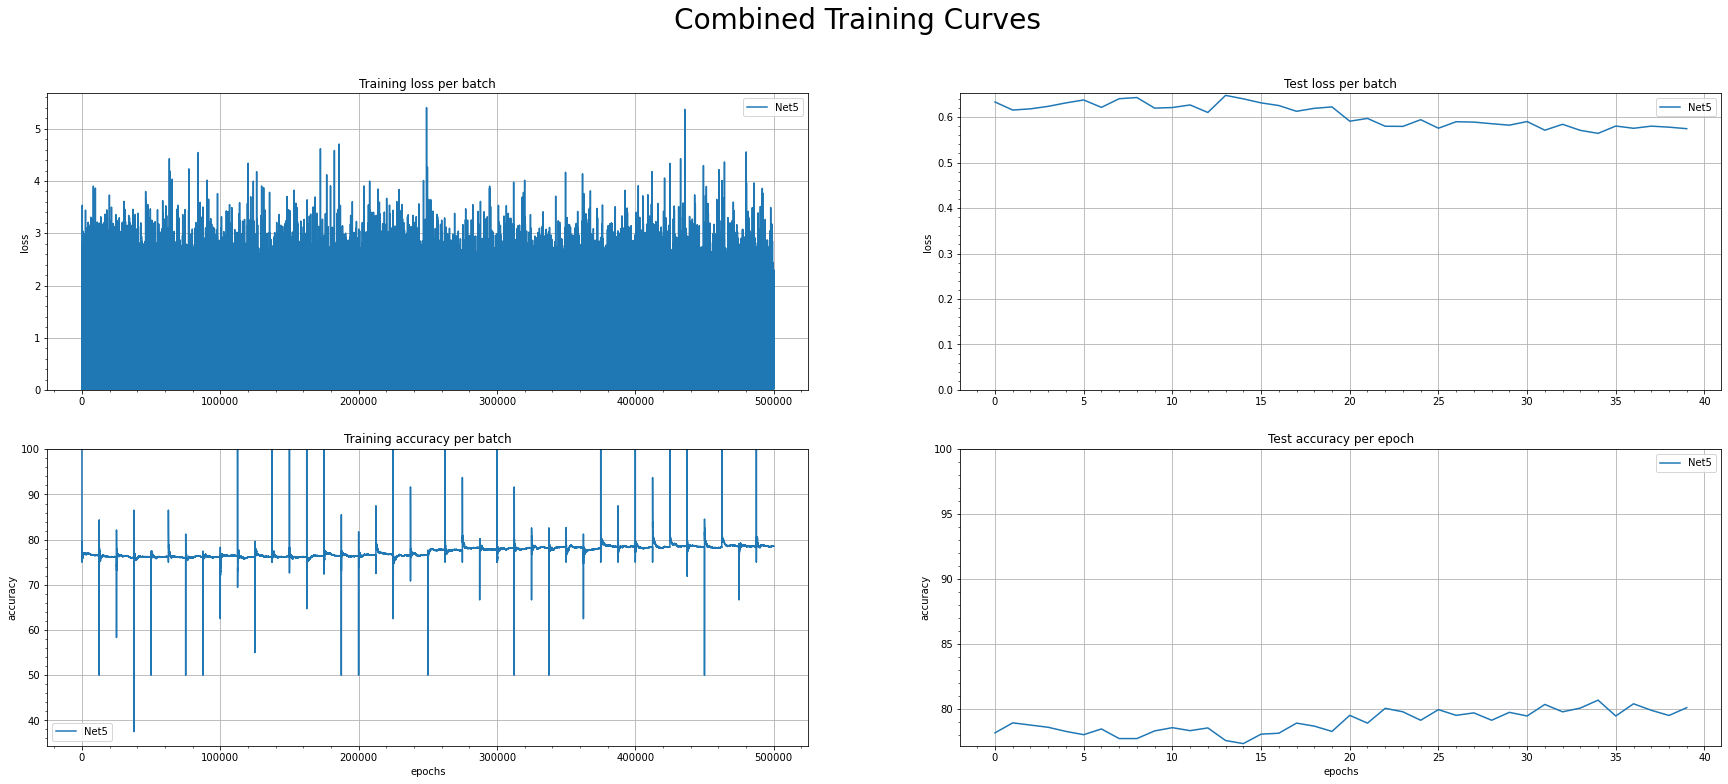

In [12]:
training_curves(history)